# **Image Captioning** 

Team Members:

1. Adarsh Rajesh

2. Durba Satpathi

3. Shubham Priyank



# Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:



ValueError: ignored

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import string
import re
import math
import pickle
from pickle import load,dump
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import torchvision
import torchvision.models as models
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
idx2word = np.load('/content/drive/MyDrive/Dataset/IndexToWord.npy',allow_pickle='TRUE').tolist() 
word2idx = np.load('/content/drive/MyDrive/Dataset/WordToIndex.npy',allow_pickle='TRUE').tolist() 
vocab_length=len(word2idx)

# Loading the ResNet18 Model

In [ ]:
#loads cuda as the device being used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#download resNet18 from torchvision
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [ ]:
#get the layer4 of resNet18 
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

# Generate Image Embeddings

In [ ]:
 class transform_image():
  def __init__(self, data):
        self.data = data 
        # resize the image to 224*224 to feed it as input to resnet18 model
        self.scaler = transforms.Resize([224, 224])  
        # normalize the image
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) 
        # converts the images to tensors
        self.to_tensor = transforms.ToTensor() 
  def __len__(self):  
        return self.data.shape[0]
  def __getitem__(self,idx):
        image_name = self.data.iloc[idx]['image']
        transformed_img= self.normalize(self.to_tensor(self.scaler(Image.open('/content/'+str(image_name)))))
        return image_name, transformed_img

# function that returns the extracted vector embeddings of the transformed image and save the encodings as .pkl file.   
def get_Embeddings_ResNet(df,fname):
  #get the unique images from the dataframe because each each image has 5 sets of captions in the dataframe
  unq_image=df[['image']].drop_duplicates()
  #resize and normalize the image using the transform_image() function
  Dataset_ResNet = transform_image(unq_image)
  #create a dataloader of the transformed images
  Dataloader = DataLoader(Dataset_ResNet, batch_size = 1, shuffle=False) 
  #initialise an empty dictionary where we will store embeddings in the form image id: embedding
  Extracted_resnet = {}
  for image_name, transformed_img in Dataloader:
    #convert the tensor to variable (because transformed image function returns a tensor)
    transformed_img = Variable(transformed_img.to(device))
    #creating a tensor filled with 0s of size [1,512,7,7] in accordance to size of resnet18 layer 4
    emb = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        emb.copy_(o.data)   
    h = resNet18Layer4.register_forward_hook(copy_data)
    #feed forward the image through resNet
    resnet18(transformed_img) 
    h.remove()    
    #store the embedding generated in the dictionary
    Extracted_resnet[image_name[0]] = emb
  img_file = open(fname, "wb")
  #save the dictionary as a .pkl file
  pickle.dump(Extracted_resnet, img_file)
  img_file.close()
  #return the dictionary
  return Extracted_resnet


# Transformer Decoder

In [ ]:
'''
>> Positional encoding is a re-representation of the values of a word and its position in a sentence
>> Positional encoder takes help of the cyclic nature of sin(x) and cos(x) functions 
   and returns information of the position of a word in a sentence
>> Positional Encoding(pos,2i)=sin(pos/10000^(2i/d))
   Positional Encoding(pos,2i+1)=cos(pos/10000^(2i/d))
   where 
   *pos is the position of the word
   *d is the size of the word embeding
   *i is the dimension of the embedding and can lie between [0,d-1] 

'''
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=38):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pos_encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        #get the positional encoding = sin(pos/10000^(2i/d)) and cos(pos/10000^(2i+1/d))
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        pos_encoding = pos_encoding.unsqueeze(0)
        self.register_buffer('pos_encoding', pos_encoding)
    def forward(self, x):
        if self.pos_encoding.size(0) < x.size(0):
            self.pos_encoding = self.pos_encoding.repeat(x.size(0), 1, 1).to(device)
        self.pos_encoding = self.pos_encoding[:x.size(0), : , : ]        
        x = x + self.pos_encoding
        return self.dropout(x)

In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        # d_model = embedding size , nhead = number of attention heads
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head) 
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights() 
    # initializing the weights of embedding layer from uniform distribution
    def init_weights(self):
         initrange = 0.1
         self.embedding.weight.data.uniform_(-initrange, initrange) 
         self.last_linear_layer.bias.data.zero_()
         self.last_linear_layer.weight.data.uniform_(-initrange, initrange) 
    # Padding mask is applied. The cross entropy loss will be masked during training at time steps where input token is <'Aspace'>.
    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))
        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0
        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool
    # Feed forward layers of the transformer decoder network
    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)       
        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)      
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)       
        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)       
        final_output = self.last_linear_layer(decoder_output)
        return final_output,  decoder_input_pad_mask


# Generate captions for custom user fed images

In [ ]:
model = torch.load('/content/drive/MyDrive/Dataset/BestModel',map_location=torch.device('cpu'))

In [ ]:
model

ImageCaptionModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoderLayer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoder): Transfor

In [ ]:
import random

model = torch.load('/content/drive/MyDrive/Dataset/BestModel',map_location=torch.device('cpu'))     # Model trained with ResNet18+Transformer awithout data augmentation.
#model = torch.load('/content/drive/MyDrive/Dataset/BestModelaug',map_location=torch.device('cpu')) # Model trained with ResNet18+Transformers and data augmentation.
#model = torch.load('/content/drive/MyDrive/Dataset/BestModel50',map_location=torch.device('cpu'))  # Model trained with ResNet50+Transformer without data augmentation.

start_token = word2idx['<START>']
end_token = word2idx['<END>']
pad_token = word2idx['<Aspace>']
max_seq_len = 36
def custom_img_predict(K,fname):
  img_loc = '/content/'+str(fname)
  image = Image.open(img_loc).convert("RGB")
  plt.imshow(image)
  model.eval()
  # Converting the custom img name to dataframe to feed into ResNet18 dataloader and get the embeddings
  data = {'image':[str(fname)]}
  df = pd.DataFrame(data)
  emb = get_Embeddings_ResNet(df,"new_image_encoded.pkl")
  # Saving the encodings in .pkl file
  valid_img_embed = pd.read_pickle('new_image_encoded.pkl')
  #getting the image encodings from encoding file saved earlier.
  img_embed = valid_img_embed[fname].to(device)
  img_embed = img_embed.permute(0,2,3,1)
  img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))  
  # Preparing the input sequence to be fed in the model
  input_seq = [pad_token]*max_seq_len
  input_seq[0] = start_token
  input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
  predicted_sentence = []
  with torch.no_grad():
      for eval_iter in range(0, max_seq_len-1):
          # Feeding the image embeddings and input sequence into the model and getting the output
          output, padding_mask = model.forward(img_embed, input_seq)
          output = output[eval_iter, 0, :]         
          # Predicts the top K captions for the custom image
          values = torch.topk(output, K).values.tolist()
          indices = torch.topk(output, K).indices.tolist()
          next_word_index = random.choices(indices, values, k = 1)[0]
          next_word = idx2word[next_word_index]
          input_seq[:, eval_iter+1] = next_word_index
          if next_word == '<END>' :
              break
          predicted_sentence.append(next_word)
  return " ".join(predicted_sentence+['.'])

Saving part.jpg to part (1).jpg
part.jpg
Caption 1: a white and black dog is jumping through a blue and white car .
part.jpg
Caption 2: a white dog is jumping through a blue and blue car .
part.jpg
Caption 3: a white dog with his head and black pants and white is jumping on the steps in front .
part.jpg
Caption 4: there is the water and the dog on the track with his bicycle in the background and blue and a white and blue pants .
part.jpg
Caption 5: two women walking across a track .


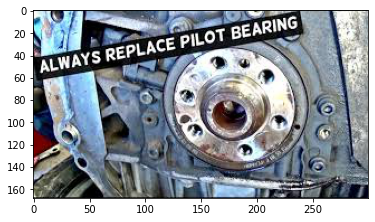

In [ ]:
import IPython
html_code = \
'''
<html>
<head>
<style type="text/css">
hr {
   border: 1px solid #b603fc;
   margin-bottom: 25px;
}
.formContainer {
   padding: 16px;
   width: 100%;
}
</style>
</head>
<body style="background: #3a0e6d;">
<form>
<div class="formContainer" style="background-image: linear-gradient(to bottom right,#f0dbff, #fcf7ff);">
<h1>Image Captioning Model</h1>
<hr>
</div>
</form>
</body>
</html>
'''
display(IPython.display.HTML(html_code))
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    for i in range(1,6):
        print(fn)
        print("Caption "+str(i)+": "+ custom_img_predict(i,fn))